# HPC Project – Parallel Sorting Algorithms (MPI & OpenMP)

This notebook analyzes the performance of sorting algorithms implemented in C:

- `quicksort_seq` (sequential)
- `mpi_mergesort`
- `mpi_bitonicsort`
- `mpi_bucketsort`
- `omp_quicksort`

We will use the CSV files generated by `run_all.sh` to:
- Compare **execution time**.
- Calculate and visualize **speedup**.
- Calculate and visualize **parallel efficiency**.
- Directly compare **MPI vs OpenMP vs sequential**.


In [1]:
import pandas as pd
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", 20)
pd.set_option("display.width", 120)

## 1. Load results from CSV files

In [2]:
seq = pd.read_csv("results_seq.csv")
mpi_merge = pd.read_csv("results_mpi_mergesort.csv")
mpi_bitonic = pd.read_csv("results_mpi_bitonic.csv")
mpi_bucket = pd.read_csv("results_mpi_bucketsort.csv")
omp = pd.read_csv("results_omp_quicksort.csv")

print("Sequential:")
display(seq.head())
print("\nMPI MergeSort:")
display(mpi_merge.head())
print("\nMPI Bitonic:")
display(mpi_bitonic.head())
print("\nMPI Bucket:")
display(mpi_bucket.head())
print("\nOpenMP QuickSort:")
display(omp.head())

Sequential:


,n,pattern,time,sorted
0,1000000,random,0.052708,yes
1,1000000,quasi,0.029849,yes
2,2000000,random,0.111652,yes
3,2000000,quasi,0.064554,yes
4,3000000,random,0.173252,yes



MPI MergeSort:


,n,pattern,time,sorted,processes
0,1000000,random,0.075419,yes,1
1,1000000,quasi,0.032776,yes,1
2,2000000,random,0.154492,yes,1
3,2000000,quasi,0.071555,yes,1
4,3000000,random,0.230537,yes,1



MPI Bitonic:


,n,pattern,time,sorted,processes
0,1000000,random,0.076698,yes,1
1,1000000,quasi,0.033996,yes,1
2,2000000,random,0.159931,yes,1
3,2000000,quasi,0.073083,yes,1
4,3000000,random,0.241930,yes,1



MPI Bucket:


,n,pattern,time,sorted,processes
0,1000000,random,0.092151,yes,1
1,1000000,quasi,0.041082,yes,1
2,2000000,random,0.191681,yes,1
3,2000000,quasi,0.086263,yes,1
4,3000000,random,0.285647,yes,1



OpenMP QuickSort:


,n,pattern,threads,time,sorted
0,1000000,random,1,0.045135,yes
1,1000000,quasi,1,0.039128,yes
2,2000000,random,1,0.097441,yes
3,2000000,quasi,1,0.092754,yes
4,3000000,random,1,0.149522,yes


## 2. Unify and standardize data in a single DataFrame

In [3]:
# Sequential QuickSort
seq = seq.copy()
seq["model"] = "sequential"
seq["algorithm"] = "quicksort_seq"
seq["procs"] = 1
seq["threads"] = 1

# MPI MergeSort
mpi_merge = mpi_merge.copy()
mpi_merge["model"] = "mpi"
mpi_merge["algorithm"] = "mpi_mergesort"
mpi_merge.rename(columns={"processes": "procs"}, inplace=True)
mpi_merge["threads"] = 1

# MPI Bitonic
mpi_bitonic = mpi_bitonic.copy()
mpi_bitonic["model"] = "mpi"
mpi_bitonic["algorithm"] = "mpi_bitonic"
mpi_bitonic.rename(columns={"processes": "procs"}, inplace=True)
mpi_bitonic["threads"] = 1

# MPI BucketSort
mpi_bucket = mpi_bucket.copy()
mpi_bucket["model"] = "mpi"
mpi_bucket["algorithm"] = "mpi_bucketsort"
mpi_bucket.rename(columns={"processes": "procs"}, inplace=True)
mpi_bucket["threads"] = 1

# OpenMP QuickSort
omp = omp.copy()
omp["model"] = "openmp"
omp["algorithm"] = "omp_quicksort"
# In results_omp_quicksort.csv we already have the 'threads' column
omp["procs"] = 1  # it's a single process with multiple threads

# Unify all data
all_data = pd.concat([seq, mpi_merge, mpi_bitonic, mpi_bucket, omp], ignore_index=True)

print("Unified data:")
display(all_data.head())

print("\nAlgorithms present:", all_data["algorithm"].unique())
print("Models present:", all_data["model"].unique())
print("Patterns present:", all_data["pattern"].unique())

Unified data:


,n,pattern,time,sorted,model,algorithm,procs,threads
0,1000000,random,0.052708,yes,sequential,quicksort_seq,1,1
1,1000000,quasi,0.029849,yes,sequential,quicksort_seq,1,1
2,2000000,random,0.111652,yes,sequential,quicksort_seq,1,1
3,2000000,quasi,0.064554,yes,sequential,quicksort_seq,1,1
4,3000000,random,0.173252,yes,sequential,quicksort_seq,1,1



Algorithms present: ['quicksort_seq' 'mpi_mergesort' 'mpi_bitonic' 'mpi_bucketsort'
 'omp_quicksort']
Models present: ['sequential' 'mpi' 'openmp']
Patterns present: ['random' 'quasi']


## 3. Calculate *speedup* and *efficiency* relative to the sequential version

In [4]:
# Baseline: sequential time by (n, pattern)

baseline = (
    seq[["n", "pattern", "time"]]
    .groupby(["n", "pattern"], as_index=False)
    .mean()
    .rename(columns={"time": "T_seq"})
)

baseline

,n,pattern,T_seq
0,1000000,quasi,0.029849
1,1000000,random,0.052708
2,2000000,quasi,0.064554
3,2000000,random,0.111652
4,3000000,quasi,0.097094
5,3000000,random,0.173252
6,4000000,quasi,0.128208
7,4000000,random,0.242596
8,5000000,quasi,0.164654
9,5000000,random,0.314142


In [5]:
# Unify baseline with all data
df = all_data.merge(baseline, on=["n", "pattern"], how="left")

# NNumber of processing elements P:

# - For MPI: number of processes
# - For OpenMP: number of threads
# - For sequential: P = 1
def compute_P(row):
    if row["model"] == "mpi":
        return row["procs"]
    elif row["model"] == "openmp":
        return row["threads"]
    else:
        return 1

df["P"] = df.apply(compute_P, axis=1)

# Speedup and efficiency
df["speedup"] = df["T_seq"] / df["time"]
df["efficiency"] = df["speedup"] / df["P"]

print("DataFrame with metrics:")
display(df.head())

DataFrame with metrics:


,n,pattern,time,sorted,model,algorithm,procs,threads,T_seq,P,speedup,efficiency
0,1000000,random,0.052708,yes,sequential,quicksort_seq,1,1,0.052708,1,1.0,1.0
1,1000000,quasi,0.029849,yes,sequential,quicksort_seq,1,1,0.029849,1,1.0,1.0
2,2000000,random,0.111652,yes,sequential,quicksort_seq,1,1,0.111652,1,1.0,1.0
3,2000000,quasi,0.064554,yes,sequential,quicksort_seq,1,1,0.064554,1,1.0,1.0
4,3000000,random,0.173252,yes,sequential,quicksort_seq,1,1,0.173252,1,1.0,1.0


## 4. Auxiliary functions for generating graphs

In [6]:
def plot_time_vs_P(df, n, pattern):
    subset = df[(df["n"] == n) & (df["pattern"] == pattern)].copy()
    subset = subset[subset["model"] != "sequential"]  # optional: remove sequential from the curve

    if subset.empty:
        print(f"No data for n={n}, pattern={pattern}")
        return

    plt.figure()
    for alg, group in subset.groupby("algorithm"):
        g = group.sort_values("P")
        plt.plot(g["P"], g["time"], marker="o", label=alg)

    # Add sequential reference as a horizontal line
    t_seq = subset["T_seq"].iloc[0]
    plt.axhline(y=t_seq, linestyle="--", label="sequential (T_seq)")

    plt.xlabel("Processing elements (P = MPI processes or OpenMP threads)")
    plt.ylabel("Time (s)")
    plt.title(f"Time vs P (n={n}, pattern={pattern})")
    plt.grid(True)
    plt.legend()
    plt.show()


def plot_speedup_vs_P(df, n, pattern):
    subset = df[(df["n"] == n) & (df["pattern"] == pattern)].copy()
    subset = subset[subset["model"] != "sequential"]

    if subset.empty:
        print(f"No data for n={n}, pattern={pattern}")
        return

    plt.figure()
    for alg, group in subset.groupby("algorithm"):
        g = group.sort_values("P")
        plt.plot(g["P"], g["speedup"], marker="o", label=alg)

    # Ideal line S=P
    P_vals = sorted(subset["P"].unique())
    plt.plot(P_vals, P_vals, linestyle="--", label="ideal (S = P)")

    plt.xlabel("Processing elements (P)")
    plt.ylabel("Speedup")
    plt.title(f"Speedup vs P (n={n}, pattern={pattern})")
    plt.grid(True)
    plt.legend()
    plt.show()


def plot_efficiency_vs_P(df, n, pattern):
    subset = df[(df["n"] == n) & (df["pattern"] == pattern)].copy()
    subset = subset[subset["model"] != "sequential"]

    if subset.empty:
        print(f"No data for n={n}, pattern={pattern}")
        return

    plt.figure()
    for alg, group in subset.groupby("algorithm"):
        g = group.sort_values("P")
        plt.plot(g["P"], g["efficiency"], marker="o", label=alg)

    plt.xlabel("Processing elements (P)")
    plt.ylabel("Efficiency (S/P)")
    plt.title(f"Efficiency vs P (n={n}, pattern={pattern})")
    plt.grid(True)
    plt.legend()
    plt.show()

## 5. Time vs. problem size (n) for a fixed P

In [7]:

def plot_time_vs_n_all(df, pattern, mpi_procs=4, omp_threads=4):
    # Sequential (implicit P = 1)
    seq_sub = df[
        (df["model"] == "sequential") &
        (df["pattern"] == pattern)
    ].copy()

    # MPI with fixed processes
    mpi_sub = df[
        (df["model"] == "mpi") &
        (df["procs"] == mpi_procs) &
        (df["pattern"] == pattern)
    ].copy()

    # OpenMP with fixed threads
    omp_sub = df[
        (df["model"] == "openmp") &
        (df["threads"] == omp_threads) &
        (df["pattern"] == pattern)
    ].copy()

    if seq_sub.empty and mpi_sub.empty and omp_sub.empty:
        print(f"No data for pattern={pattern}")
        return

    plt.figure()

    # Sequential: a single curve
    if not seq_sub.empty:
        g = seq_sub.sort_values("n")
        plt.plot(g["n"], g["time"], marker="o", label="quicksort_seq (sequential)")

    # MPI: one curve per MPI algorithm with procs=mpi_procs
    if not mpi_sub.empty:
        for alg, group in mpi_sub.groupby("algorithm"):
            g = group.sort_values("n")
            plt.plot(g["n"], g["time"], marker="o", label=f"{alg} (MPI, P={mpi_procs})")

    # OpenMP: a single curve for omp_quicksort with threads=omp_threads
    if not omp_sub.empty:
        g = omp_sub.sort_values("n")
        plt.plot(g["n"], g["time"], marker="o", label=f"omp_quicksort (OpenMP, threads={omp_threads})")

    plt.xlabel("Problem size (n)")
    plt.ylabel("Time (s)")
    plt.title(f"Time vs n – pattern={pattern}")
    plt.grid(True)
    plt.legend()
    plt.show()

## 6. Generate graphs for cases of interest

In [8]:
ns = sorted(df["n"].unique())
patterns = sorted(df["pattern"].unique())

print("Available n values:", ns)
print("Available patterns:", patterns)

Available n values: [np.int64(1000000), np.int64(2000000), np.int64(3000000), np.int64(4000000), np.int64(5000000), np.int64(6000000), np.int64(7000000), np.int64(8000000), np.int64(9000000), np.int64(10000000), np.int64(20000000)]
Available patterns: ['quasi', 'random']


Plotting for n=20000000, pattern=random



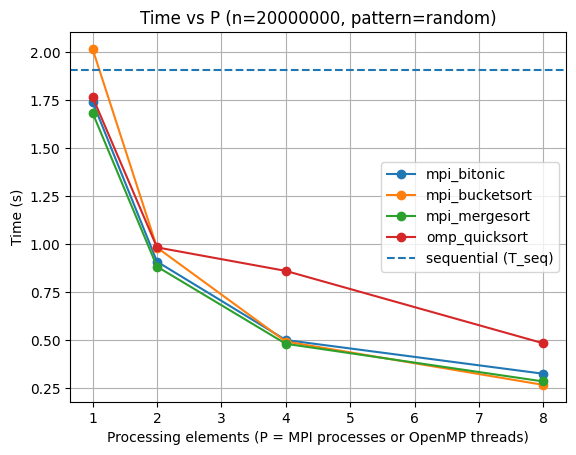

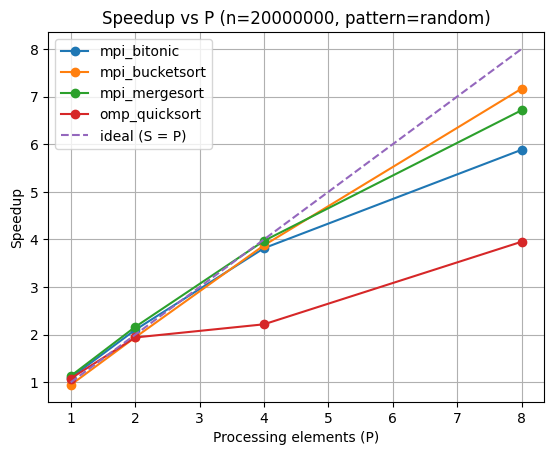

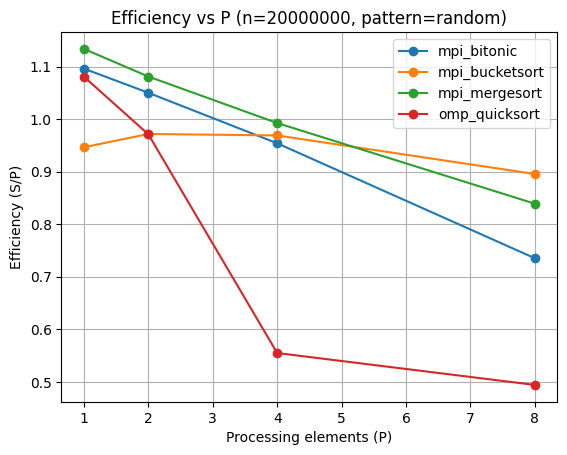

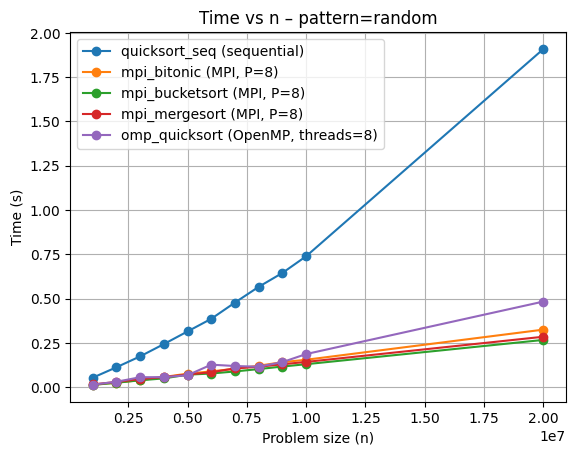

In [9]:
if ns and patterns:
    n_fix = ns[-1] # the largest n
    pat_fix = patterns[1]

    print(f"Plotting for n={n_fix}, pattern={pat_fix}\n")

    plot_time_vs_P(df, n_fix, pat_fix)
    plot_speedup_vs_P(df, n_fix, pat_fix)
    plot_efficiency_vs_P(df, n_fix, pat_fix)

    # Using, for example, P=8 processes for MPI and 8 threads for OpenMP
    if 8 in df["P"].unique():
        plot_time_vs_n_all(df, pat_fix, mpi_procs=8, omp_threads=8)


In [10]:
def plot_mpi_time_vs_n_all_P(df, algorithm="mpi_mergesort", pattern="random"):

    # Filter only MPI, algorithm, and pattern
    sub = df[
        (df["model"] == "mpi") &
        (df["algorithm"] == algorithm) &
        (df["pattern"] == pattern)
    ].copy()

    if sub.empty:
        print(f"No MPI data for algorithm={algorithm}, pattern={pattern}")
        
        return

    grouped = (
        sub.groupby(["procs", "n"], as_index=False)["time"]
           .mean()
           .sort_values(["procs", "n"])
    )

    plt.figure()

    # One line for each number of processes
    for p, g in grouped.groupby("procs"):
        g = g.sort_values("n")
        plt.plot(g["n"], g["time"], marker="o", label=f"P = {p}")

    plt.xlabel("Size of the problem (n)")
    plt.ylabel("Time (s)")
    plt.title(f"Time vs n for all processes\nAlgorithm: {algorithm}, pattern: {pattern}")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


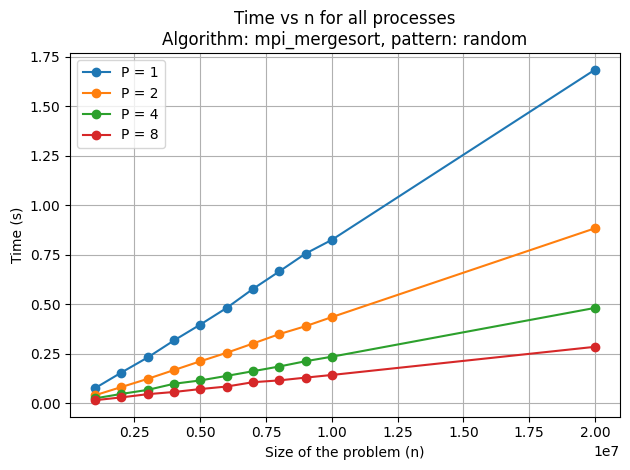

In [11]:
plot_mpi_time_vs_n_all_P(df, algorithm="mpi_mergesort", pattern="random")

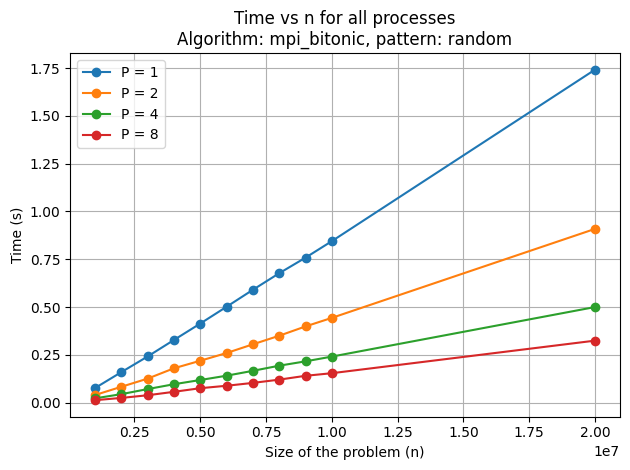

In [12]:
plot_mpi_time_vs_n_all_P(df, algorithm="mpi_bitonic", pattern="random")

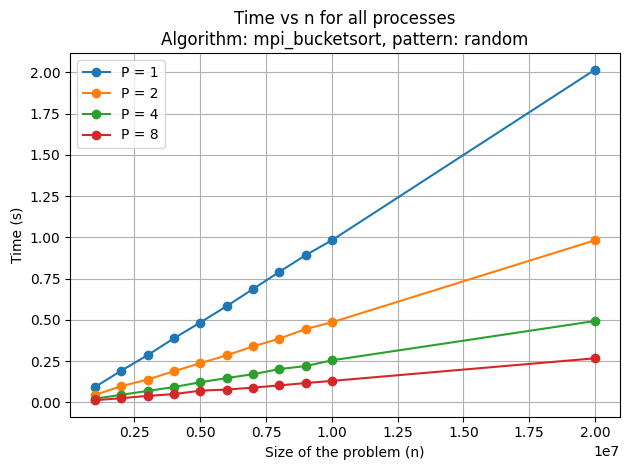

In [13]:
plot_mpi_time_vs_n_all_P(df, algorithm="mpi_bucketsort", pattern="random")

In [14]:
def plot_omp_time_vs_n_all_T(df, algorithm="omp_quicksort", pattern="random"):

    # Filter only OpenMP, algorithm, and pattern
    sub = df[
        (df["model"] == "openmp") &
        (df["algorithm"] == algorithm) &
        (df["pattern"] == pattern)
    ].copy()

    if sub.empty:
        print(f"No OpenMP data for algorithm={algorithm}, pattern={pattern}")
        
        return

    grouped = (
        sub.groupby(["threads", "n"], as_index=False)["time"]
           .mean()
           .sort_values(["threads", "n"])
    )

    plt.figure()

    # One line for each number of threads
    for t, g in grouped.groupby("threads"):
        g = g.sort_values("n")
        plt.plot(g["n"], g["time"], marker="o", label=f"threads = {t}")

    plt.xlabel("Problem size (n)")
    plt.ylabel("Time (s)")
    plt.title(f"Time vs n for all threads\nAlgorithm: {algorithm}, pattern: {pattern}")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

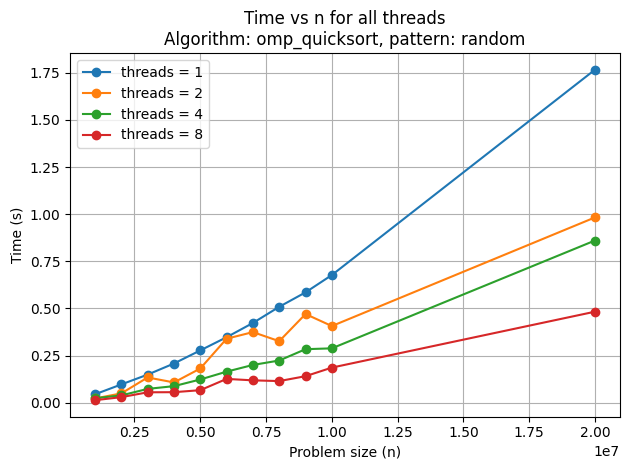

In [15]:
plot_omp_time_vs_n_all_T(df, algorithm="omp_quicksort", pattern="random")